In [33]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import csv
plt.style.use('fivethirtyeight')

In [34]:
# importing the data
df = yf.download("INFY.NS", start="2019-08-01", end="2021-07-31")

[*********************100%***********************]  1 of 1 completed


In [35]:
df['Date'] = df.index
df= df.set_index(pd.DatetimeIndex(df['Date'].values))
df

,Open,High,Low,Close,Adj Close,Volume,Date
2019-08-01,786.450012,788.400024,764.400024,768.849976,725.582397,10066407,2019-08-01
2019-08-02,765.049988,779.900024,762.250000,775.599976,731.952515,10838336,2019-08-02
2019-08-05,772.599976,785.900024,768.650024,776.700012,732.990723,9976238,2019-08-05
2019-08-06,778.799988,783.700012,769.799988,774.450012,730.867310,9331718,2019-08-06
2019-08-07,778.900024,783.450012,772.349976,776.099976,732.424438,5130457,2019-08-07
...,...,...,...,...,...,...,...
2021-07-26,1594.099976,1611.650024,1594.099976,1603.900024,1603.900024,4586710,2021-07-26
2021-07-27,1605.000000,1609.300049,1597.900024,1602.550049,1602.550049,5892859,2021-07-27
2021-07-28,1605.099976,1607.599976,1585.500000,1605.599976,1605.599976,4686788,2021-07-28
2021-07-29,1600.099976,1620.000000,1600.099976,1617.000000,1617.000000,4660873,2021-07-29


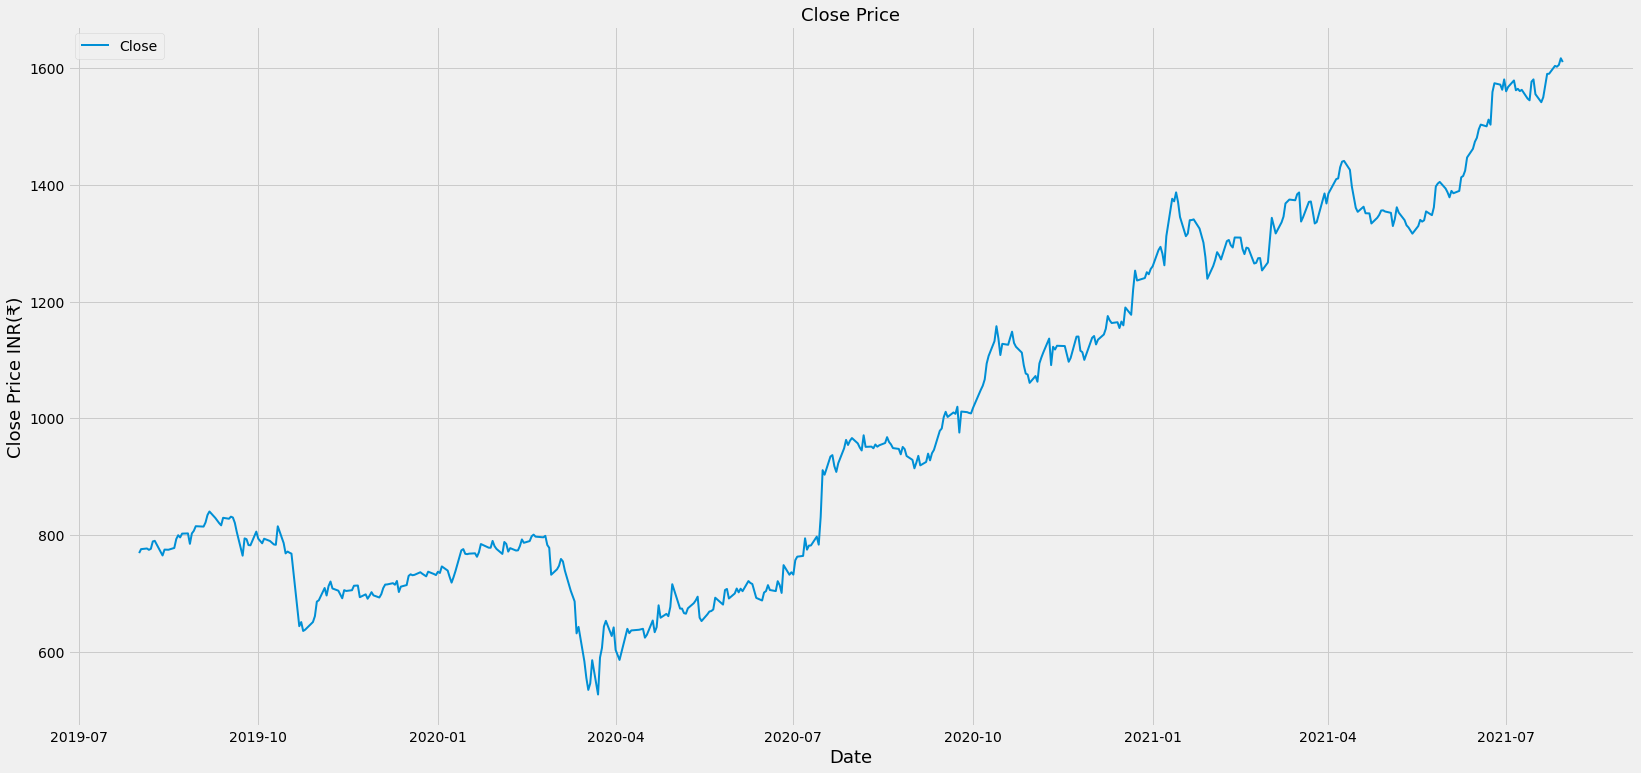

In [36]:
# Visualizing the data
plt.figure(figsize=(25,12))
plt.title('Close Price', fontsize=18)
plt.plot(df['Close'], label= 'Close',linewidth=2.0)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR(₹)', fontsize=18)
plt.legend(loc='upper left')
plt.show()

# Trading Strategy

### Since from the training period we saw that RSI gives maximum return, thus RSI strategy is used

# RSI (Relative Strength Index)

In [37]:
# Prepare the data to calculate RSI

# Get the difference in Price from previous day
delta = df['Close'].diff(1)
delta = delta.dropna()
delta

2019-08-02     6.750000
2019-08-05     1.100037
2019-08-06    -2.250000
2019-08-07     1.649963
2019-08-08    12.650024
                ...    
2021-07-26    13.450073
2021-07-27    -1.349976
2021-07-28     3.049927
2021-07-29    11.400024
2021-07-30    -6.500000
Name: Close, Length: 491, dtype: float64

In [38]:
# Get the Positive Gain and Negative Gain
up = delta.copy()
down = delta.copy()
up[up<0] = 0
down[down > 0] = 0

In [39]:
# Time period
period = 14

# Calculate average gain and loss
avg_gain = up.rolling(window=period).mean()
avg_loss = abs(down.rolling(window=period).mean())

In [40]:
# Calculate the RS
RS = avg_gain/avg_loss

# Calculate the RSI
RSI = 100.0 - (100.0 / (1.0 + RS))

In [41]:
# Creating new Dataframe
dframe = pd.DataFrame()
dframe['Date'] = df['Date']
dframe['Close'] = df['Close']
dframe['RSI'] = RSI
dframe

,Date,Close,RSI
2019-08-01,2019-08-01,768.849976,NaN
2019-08-02,2019-08-02,775.599976,NaN
2019-08-05,2019-08-05,776.700012,NaN
2019-08-06,2019-08-06,774.450012,NaN
2019-08-07,2019-08-07,776.099976,NaN
...,...,...,...
2021-07-26,2021-07-26,1603.900024,56.920949
2021-07-27,2021-07-27,1602.550049,62.238403
2021-07-28,2021-07-28,1605.599976,62.386689
2021-07-29,2021-07-29,1617.000000,66.252501


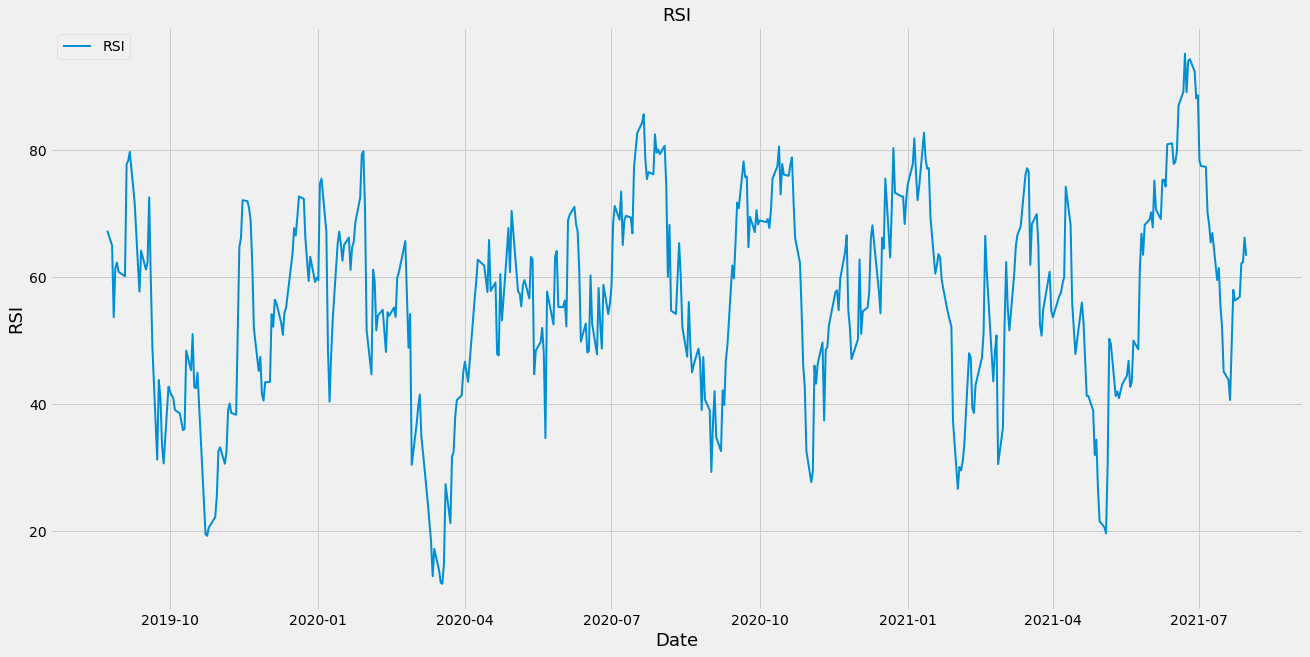

In [42]:
# Plot the data
plt.figure(figsize=(20,10))
plt.title('RSI', fontsize=18)
plt.plot(dframe['RSI'], label = "RSI", lw = 2.0)
plt.xlabel('Date', fontsize=18)
plt.ylabel('RSI', fontsize=18)
plt.legend(loc='upper left')
plt.show()

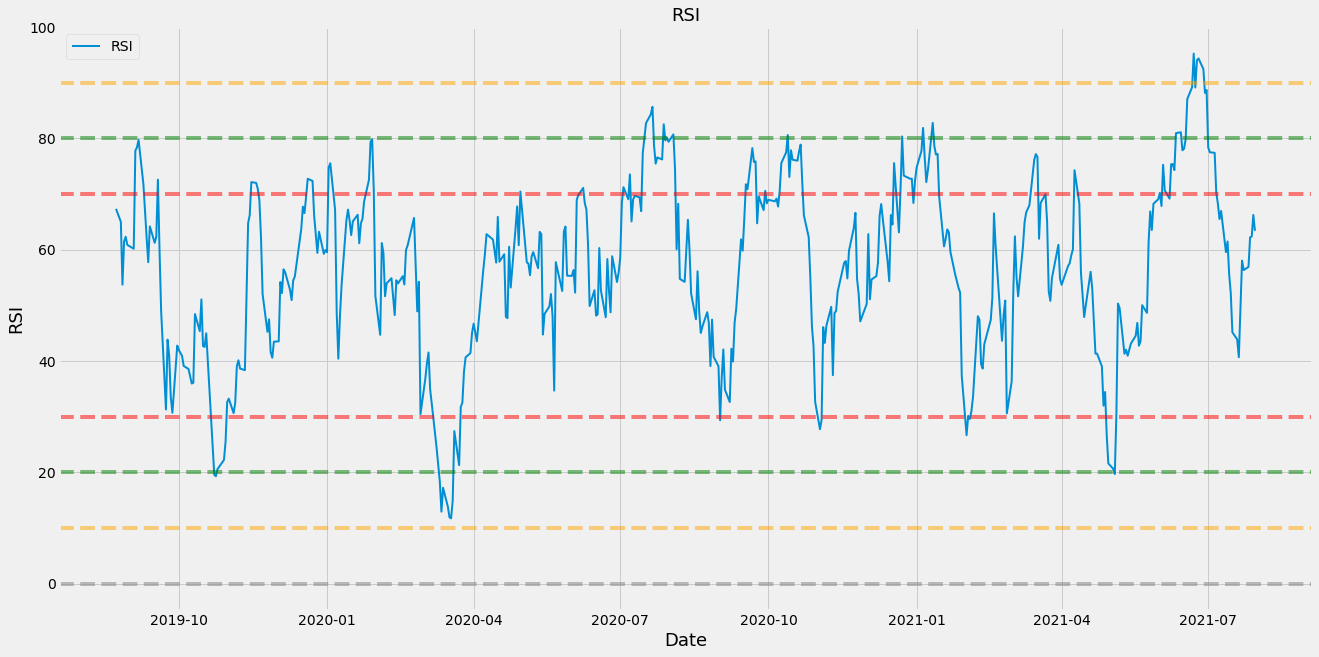

In [43]:
# Plot the RSI values and significant levels
plt.figure(figsize=(20,10))
plt.title('RSI', fontsize=18)
plt.plot(dframe['RSI'], label = "RSI", lw = 2.0)
plt.axhline(0, linestyle = '--', alpha = 0.5, color = "grey")
plt.axhline(10, linestyle = '--', alpha = 0.5, color = "orange")
plt.axhline(20, linestyle = '--', alpha = 0.5, color = "green")
plt.axhline(30, linestyle = '--', alpha = 0.5, color = "red")
plt.axhline(70, linestyle = '--', alpha = 0.5, color = "red")
plt.axhline(80, linestyle = '--', alpha = 0.5, color = "green")
plt.axhline(90, linestyle = '--', alpha = 0.5, color = "orange")
plt.axhline(100, linestyle = '--', alpha = 0.5, color = "grey")
plt.xlabel('Date', fontsize=18)
plt.ylabel('RSI', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [44]:
def buy_sell_rsi(data):
    buy_signal = []
    sell_signal = []
    position = []
    for i in range (len(data)-1):
        if data['RSI'][i] > 70 and data['RSI'][i+1] <= 70:
            buy_signal.append(np.nan)
            sell_signal.append(data['Close'][i])
            position.append(1)
        elif data['RSI'][i]<30 and data['RSI'][i+1] >= 30:
            buy_signal.append(data['Close'][i])
            sell_signal.append(np.nan)
            position.append(0)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            position.append(-1)

    buy_signal.append(np.nan)
    sell_signal.append(np.nan)
    position.append(-1)
    return(buy_signal, sell_signal, position)


In [45]:
buy_sell_signal = buy_sell_rsi(dframe)
dframe['Buy_Signal'] = buy_sell_signal[0]
dframe['Sell_Signal'] = buy_sell_signal[1]
dframe['Position'] = buy_sell_signal[2]

In [46]:
# Writing the buy sell signals in a file

f = open('Testing.csv','w')
writer = csv.writer(f)
row = ['Date', 'Buy', 'Sell', 'Position', 'Stocks Bought', 'Sell Price', 'Return%']
writer.writerow(row)
for i in range (len(dframe)):
    if dframe['Position'][i] != -1:
        row= [dframe['Date'][i], dframe['Buy_Signal'][i], dframe['Sell_Signal'][i], dframe['Position'][i]]
        writer.writerow(row)
f.close()

## Position Management

In [47]:
# Given that initial capital = 100000
init_capital = 100000
capital = init_capital

In [48]:
# importing the buy sell signals
sigData= pd.read_csv(r'Testing.csv')
sigData= sigData.set_index(pd.DatetimeIndex(sigData['Date'].values))
sigData

,Date,Buy,Sell,Position,Stocks Bought,Sell Price,Return%
2019-09-09,2019-09-09 00:00:00,NaN,829.099976,1,NaN,NaN,NaN
2019-09-18,2019-09-18 00:00:00,NaN,829.849976,1,NaN,NaN,NaN
2019-10-30,2019-10-30 00:00:00,660.599976,NaN,0,NaN,NaN,NaN
2019-11-19,2019-11-19 00:00:00,NaN,712.849976,1,NaN,NaN,NaN
2019-12-23,2019-12-23 00:00:00,NaN,736.000000,1,NaN,NaN,NaN
2020-01-03,2020-01-03 00:00:00,NaN,746.000000,1,NaN,NaN,NaN
2020-01-30,2020-01-30 00:00:00,NaN,780.700012,1,NaN,NaN,NaN
2020-03-23,2020-03-23 00:00:00,526.450012,NaN,0,NaN,NaN,NaN
2020-04-30,2020-04-30 00:00:00,NaN,715.500000,1,NaN,NaN,NaN
2020-06-08,2020-06-08 00:00:00,NaN,720.849976,1,NaN,NaN,NaN


In [49]:
tocks = 0
stop_loss = capital * 95/100
position = 0
buy_signal = 0
buy_trans = 0
sell_signal = 0
sell_trans = 0

for i in range (len(sigData)):
    if not np.isnan(sigData['Buy'][i]):
        buy_signal = buy_signal + 1

        if sigData['Position'][i] == position:
            buy_trans = buy_trans + 1
            stocks = np.int(capital/sigData['Buy'][i] * 99/100)
            sigData['Stocks Bought'][i] = stocks
            position = 1

    elif not np.isnan(sigData['Sell'][i]):
        sell_signal = sell_signal +1

        if sigData['Position'][i] == position:
            sell_trans = sell_trans + 1
            capital = stocks * sigData['Sell'][i] * 99/100
            # putting stop loss
            if capital < stop_loss:
                continue
            sigData['Sell Price'][i] = capital
            position = 0
            returnPercent = (capital - init_capital)/init_capital * 100
            sigData['Return%'][i] = returnPercent



# Selling all stocks at the end if last signal was a buy signal
if position == 1:
    capital = stocks * df['Close'][-1] * 99/100
    sigData['Sell Price'][i-1] = capital
    returnPercent = (capital - init_capital)/init_capital * 100
    sigData['Return%'][i] = returnPercent


/tmp/ipykernel_15456/506290001.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stocks = np.int(capital/sigData['Buy'][i] * 99/100)
/tmp/ipykernel_15456/506290001.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigData['Stocks Bought'][i] = stocks
/tmp/ipykernel_15456/506290001.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

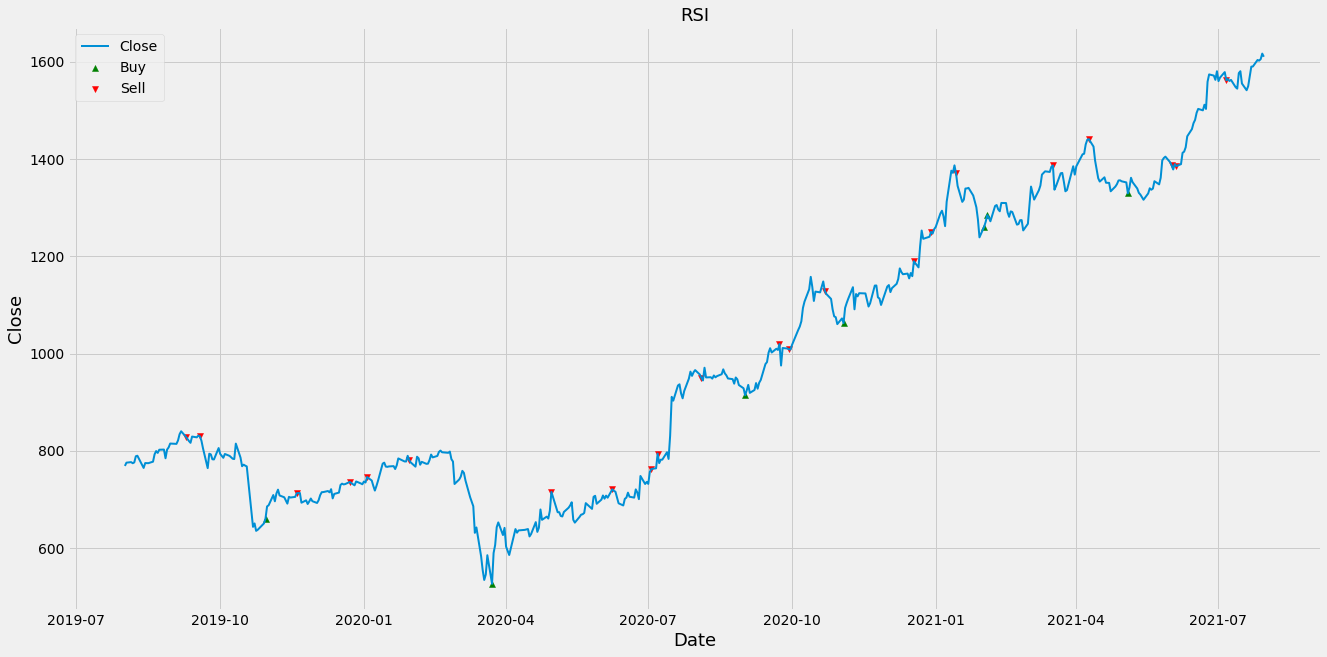

In [50]:
# Plot the buy and sell signals
plt.figure(figsize=(20,10))
plt.title('RSI', fontsize=18)
plt.plot(dframe['Close'], label = "Close", lw = 2.0)
plt.scatter(dframe.index, dframe['Buy_Signal'], label= 'Buy', marker= '^', color= 'green')
plt.scatter(dframe.index, dframe['Sell_Signal'], label= 'Sell', marker= 'v', color= 'red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [51]:
# Write in Output file

f = open('Testing.csv','w')
writer = csv.writer(f)
row = ['Date', 'Buy', 'Sell', 'Stocks Bought', 'Sell Price', 'Return%']
writer.writerow(row)
for i in range (0, len(sigData)):
    if ((not np.isnan(sigData['Buy'][i])) or (not np.isnan(sigData['Sell'][i]))) and ((not np.isnan(sigData['Stocks Bought'][i])) or (not np.isnan(sigData['Sell Price'][i]))):
        row= [sigData['Date'][i], sigData['Buy'][i], sigData['Sell'][i], sigData['Stocks Bought'][i], sigData['Sell Price'][i], sigData['Return%'][i]]
        writer.writerow(row)
f.close()

In [57]:
stockData= pd.read_csv(r'Testing.csv')
stockData= stockData.set_index(pd.DatetimeIndex(stockData['Date'].values))
stockData

,Date,Buy,Sell,Stocks Bought,Sell Price,Return%
2019-10-30,2019-10-30 00:00:00,660.599976,NaN,149.0,NaN,NaN
2019-11-19,2019-11-19 00:00:00,NaN,712.849976,NaN,105152.499899,5.152500
2020-03-23,2020-03-23 00:00:00,526.450012,NaN,197.0,NaN,NaN
2020-04-30,2020-04-30 00:00:00,NaN,715.500000,NaN,139543.965000,39.543965
2020-09-01,2020-09-01 00:00:00,914.150024,NaN,151.0,NaN,NaN
2020-09-23,2020-09-23 00:00:00,NaN,1019.750000,NaN,152442.427500,52.442427
2020-11-03,2020-11-03 00:00:00,1062.550049,NaN,142.0,NaN,NaN
2020-12-18,2020-12-18 00:00:00,NaN,1189.800049,NaN,167262.090864,67.262091
2021-02-01,2021-02-01 00:00:00,1260.900024,NaN,131.0,NaN,NaN
2021-03-17,2021-03-17 00:00:00,NaN,1387.000000,NaN,179880.030000,79.880030


In [58]:
# Calculating benchmark return

benchmark = capital * df['Close'][-1]/df['Close'][0]
benchmarkPercent = (benchmark-capital)/capital * 100

# Calculate final return Percent
returnPercent = stockData['Return%'][-1]

print('Benchmark return = ', benchmarkPercent, '%')
print('Actual Return = ', returnPercent , '%')

Benchmark return =  109.46869365153384 %
Actual Return =  82.65261757080079 %


In [59]:
# Number of Buy and Sell signals generated
print('Number of Buy Signals = ', buy_signal)
print('Number of Sell signals = ', sell_signal)

# Number of Transactions
print('Number of Buy Transactions = ', buy_trans)
print('Number of Sell transactions = ', sell_trans)

Number of Buy Signals =  7
Number of Sell signals =  22
Number of Buy Transactions =  6
Number of Sell transactions =  6


In [60]:
# Maximum Drawdown

min = df['Close'].min()
max = df['Close'].max()

drawdown = (min - max)/max * 100

print('Maximum Drawdown = ', drawdown)

Maximum Drawdown =  -67.44279454501971


In [ ]:
# Win/Loss
win = 0
loss = 0
for i in range(len(stockData)):
    if stockData['Return%'][i] < 0:
        loss = loss + 1
    elif stockData['Return%'][i] > 0:
        win = win + 1

print('Win/Loss ratio = ', win, '/', loss)